In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns', None)


In [4]:
sys.path.append(str(Path("..") / "03_src"))


In [6]:
import utils

In [7]:
orders_enriched = pd.read_csv(
    utils.path() + "\\03_curated\\orders_enriched.csv"
)


In [8]:
# ------------------------------------------------------------------
# Seller-level KPIs (Seller-Controlled Metrics Only)
# ------------------------------------------------------------------
seller_kpis = (
    orders_enriched.groupby("seller_id")
    .agg(
        order_volume=('order_id', 'count'),
        avg_processing_time=('processing_time', 'mean'),
        avg_shipping_time=('shipping_time', 'mean'),
        late_shipping_count=('late_shipping_flag', 'sum'),
        extreme_shipping_count=('extreme_shipping_flag', 'sum')
    )
    .reset_index()
)

seller_kpis['late_shipping_rate'] = seller_kpis['late_shipping_count'] / seller_kpis['order_volume']
seller_kpis['impact_score'] = seller_kpis['late_shipping_rate'] * seller_kpis['order_volume']

# Filter out very low-volume sellers
seller_kpis = seller_kpis[seller_kpis['order_volume'] >= 10]


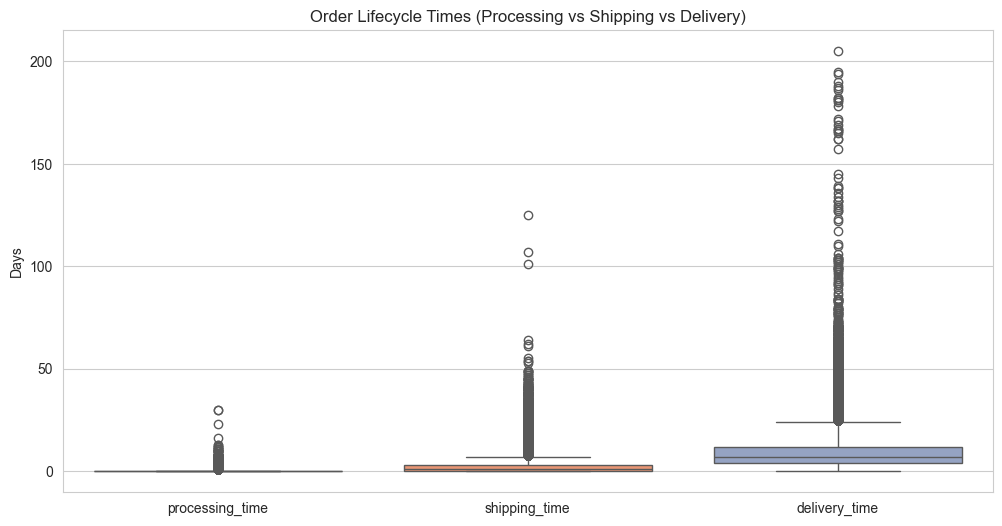

In [9]:
# ------------------------------------------------------------------
# 1. Fulfillment Stage Contribution (Diagnostic)
# ------------------------------------------------------------------
sns.boxplot(
    data=orders_enriched[['processing_time', 'shipping_time', 'delivery_time']],
    palette='Set2'
)
plt.title('Order Lifecycle Times (Processing vs Shipping vs Delivery)')
plt.ylabel('Days')
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_16408\2459867914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


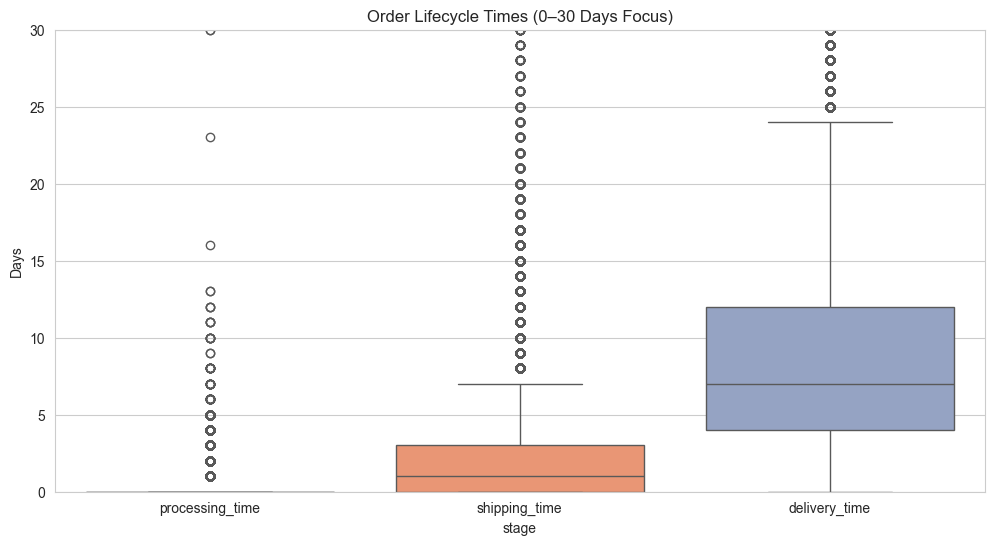

In [10]:
# Zoomed view (0–30 days)
sns.boxplot(
    data=pd.melt(
        orders_enriched[['processing_time', 'shipping_time', 'delivery_time']],
        var_name='stage',
        value_name='days'
    ),
    x='stage',
    y='days',
    palette='Set2'
)
plt.ylim(0, 30)
plt.title('Order Lifecycle Times (0–30 Days Focus)')
plt.ylabel('Days')
plt.show()


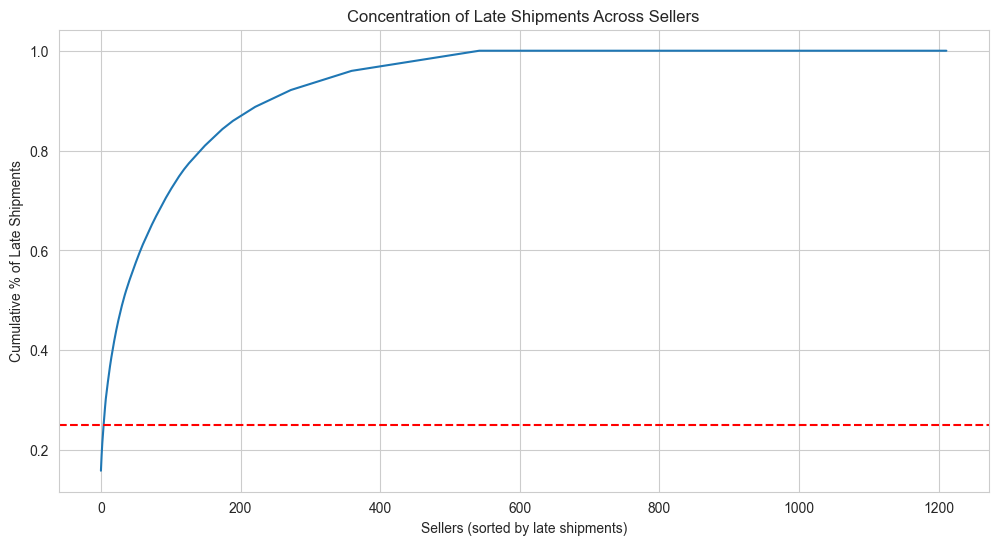

In [11]:
# ------------------------------------------------------------------
# 2. Seller Impact Concentration (Pareto)
# ------------------------------------------------------------------
seller_sorted = seller_kpis.sort_values('late_shipping_count', ascending=False)
seller_sorted['cum_late_shipments'] = seller_sorted['late_shipping_count'].cumsum()
seller_sorted['cum_pct_late'] = (
    seller_sorted['cum_late_shipments'] /
    seller_sorted['late_shipping_count'].sum()
)

plt.plot(seller_sorted['cum_pct_late'].values)
plt.axhline(0.25, linestyle='--', color='red')
plt.title('Concentration of Late Shipments Across Sellers')
plt.xlabel('Sellers (sorted by late shipments)')
plt.ylabel('Cumulative % of Late Shipments')
plt.show()


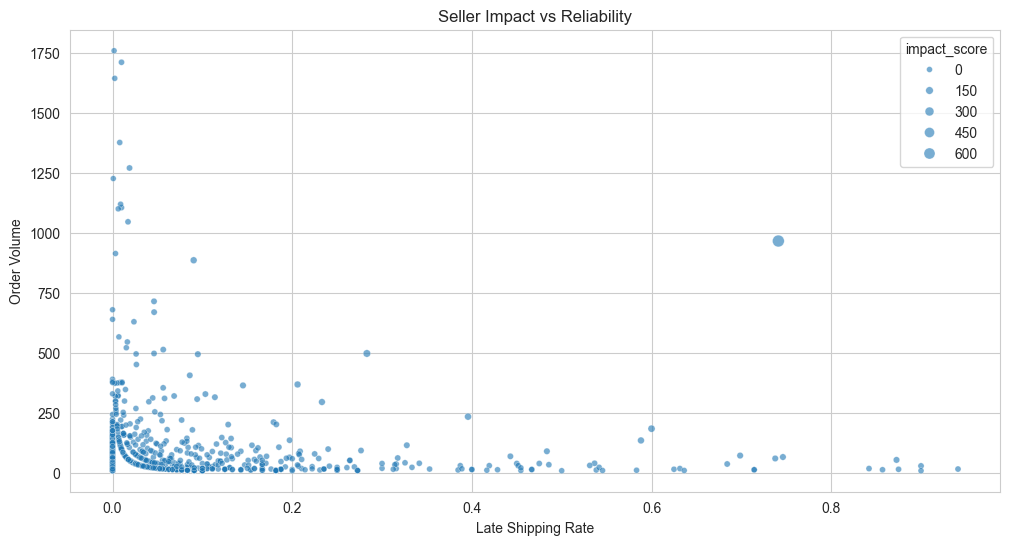

In [12]:
# ------------------------------------------------------------------
# 3. Impact vs Reliability (Core Ops View)
# ------------------------------------------------------------------
sns.scatterplot(
    data=seller_kpis,
    x='late_shipping_rate',
    y='order_volume',
    size='impact_score',
    alpha=0.6
)
plt.title('Seller Impact vs Reliability')
plt.xlabel('Late Shipping Rate')
plt.ylabel('Order Volume')
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_16408\4084268751.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


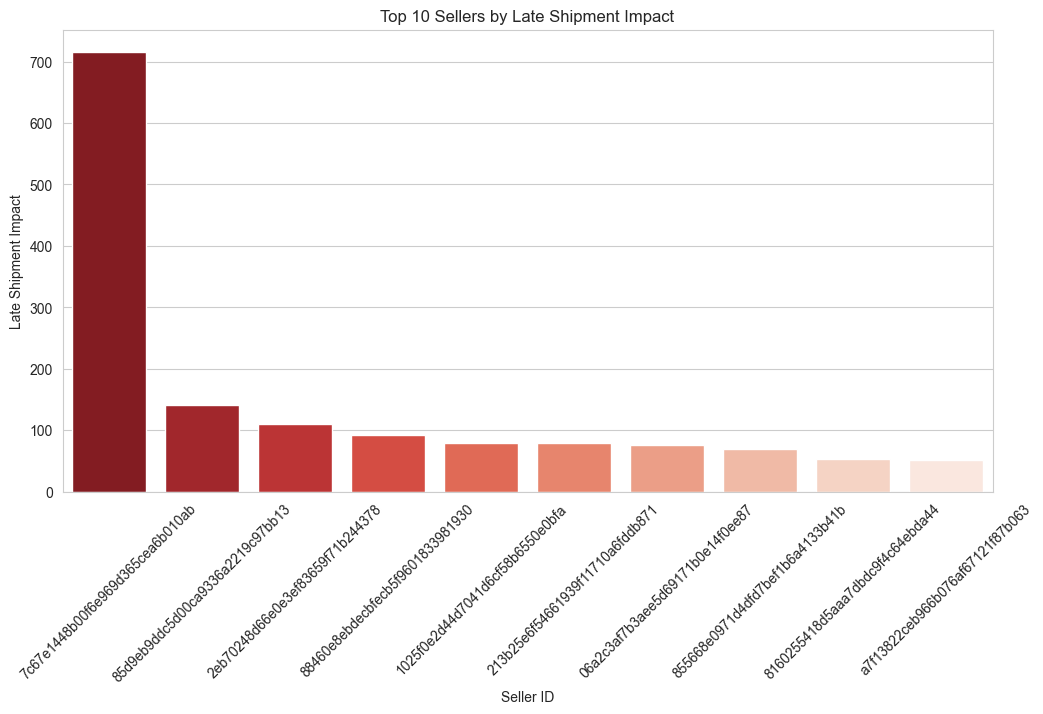

In [13]:
# ------------------------------------------------------------------
# 4. Top High-Impact Sellers
# ------------------------------------------------------------------
top_impact_sellers = seller_kpis.sort_values(
    'impact_score', ascending=False
).head(10)

sns.barplot(
    data=top_impact_sellers,
    x='seller_id',
    y='impact_score',
    palette='Reds_r'
)
plt.xticks(rotation=45)
plt.title('Top 10 Sellers by Late Shipment Impact')
plt.ylabel('Late Shipment Impact')
plt.xlabel('Seller ID')
plt.show()


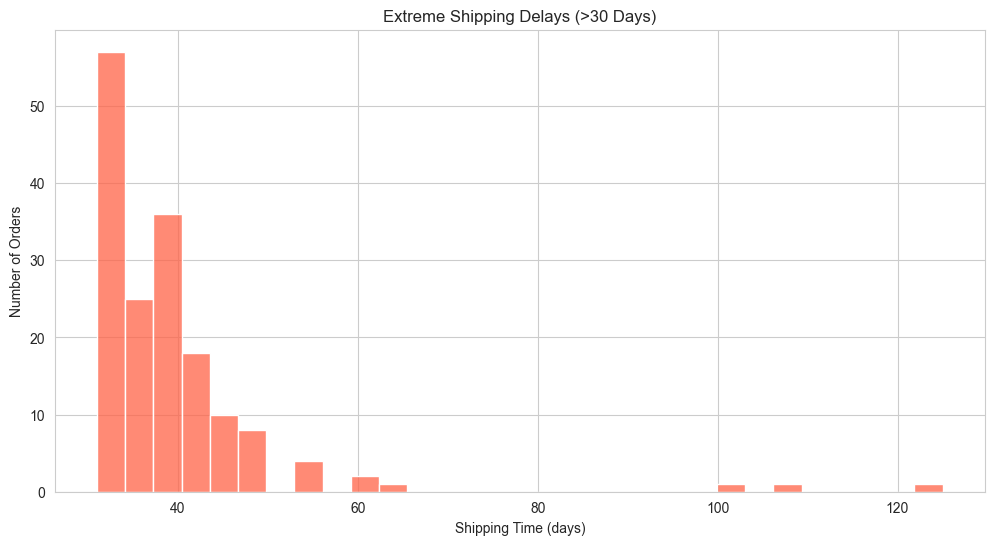

In [14]:
# ------------------------------------------------------------------
# 5. Extreme Shipping Delays (Escalation Context)
# ------------------------------------------------------------------
extreme_orders = orders_enriched[orders_enriched['extreme_shipping_flag']]

sns.histplot(
    extreme_orders['shipping_time'],
    bins=30,
    color='tomato'
)
plt.title('Extreme Shipping Delays (>30 Days)')
plt.xlabel('Shipping Time (days)')
plt.ylabel('Number of Orders')
plt.show()


In [15]:
# Summary statistics by lifecycle stage
stage_summary = orders_enriched[['processing_time', 'shipping_time', 'delivery_time']].describe().round(2)
stage_summary

,processing_time,shipping_time,delivery_time
count,95082.00,95082.00,95082.00
mean,0.24,2.35,8.91
std,0.67,3.49,8.76
min,0.00,0.00,0.00
25%,0.00,0.00,4.00
50%,0.00,1.00,7.00
75%,0.00,3.00,12.00
max,30.00,125.00,205.00


In [16]:
seller_kpis = (
    orders_enriched.groupby("seller_id")
    .agg(
        order_volume=('order_id', 'count'),
        late_shipping_count=('late_shipping_flag', 'sum')
    )
    .reset_index()
)

# Filter low-volume sellers
seller_kpis = seller_kpis[seller_kpis['order_volume'] >= 10]

seller_kpis = seller_kpis.sort_values('late_shipping_count', ascending=False)
seller_kpis['cum_late_shipments'] = seller_kpis['late_shipping_count'].cumsum()
seller_kpis['cum_pct_late'] = seller_kpis['cum_late_shipments'] / seller_kpis['late_shipping_count'].sum()

# Quantify concentration
seller_kpis.head(10)

,seller_id,order_volume,late_shipping_count,cum_late_shipments,cum_pct_late
1468,7c67e1448b00f6e969d365cea6b010ab,966,716,716,0.158758
1567,85d9eb9ddc5d00ca9336a2219c97bb13,498,141,857,0.190022
534,2eb70248d66e0e3ef83659f71b244378,185,111,968,0.214634
1594,88460e8ebdecbfecb5f9601833981930,235,93,1061,0.235255
186,1025f0e2d44d7041d6cf58b6550e0bfa,886,80,1141,0.252993
378,213b25e6f54661939f11710a6fddb871,136,80,1221,0.270732
78,06a2c3af7b3aee5d69171b0e14f0ee87,369,76,1297,0.287583
1564,855668e0971d4dfd7bef1b6a4133b41b,296,69,1366,0.302882
1520,8160255418d5aaa7dbdc9f4c64ebda44,365,53,1419,0.314634
1949,a7f13822ceb966b076af67121f87b063,73,51,1470,0.325942


In [17]:
seller_kpis['late_shipping_rate'] = seller_kpis['late_shipping_count'] / seller_kpis['order_volume']
seller_kpis['impact_score'] = seller_kpis['late_shipping_rate'] * seller_kpis['order_volume']

seller_kpis[['seller_id','order_volume','late_shipping_rate','impact_score']].sort_values(
    'impact_score', ascending=False
).head(10)

,seller_id,order_volume,late_shipping_rate,impact_score
1468,7c67e1448b00f6e969d365cea6b010ab,966,0.741201,716.0
1567,85d9eb9ddc5d00ca9336a2219c97bb13,498,0.283133,141.0
534,2eb70248d66e0e3ef83659f71b244378,185,0.600000,111.0
1594,88460e8ebdecbfecb5f9601833981930,235,0.395745,93.0
186,1025f0e2d44d7041d6cf58b6550e0bfa,886,0.090293,80.0
378,213b25e6f54661939f11710a6fddb871,136,0.588235,80.0
78,06a2c3af7b3aee5d69171b0e14f0ee87,369,0.205962,76.0
1564,855668e0971d4dfd7bef1b6a4133b41b,296,0.233108,69.0
1520,8160255418d5aaa7dbdc9f4c64ebda44,365,0.145205,53.0
1949,a7f13822ceb966b076af67121f87b063,73,0.698630,51.0


In [18]:
seller_kpis['volume_bucket'] = pd.qcut(
    seller_kpis['order_volume'],
    q=2,
    labels=['Low Volume', 'High Volume']
)

seller_kpis.groupby('volume_bucket').agg(
    avg_late_rate=('late_shipping_rate','mean'),
    avg_order_volume=('order_volume','mean'),
    avg_late_shipments=('late_shipping_count','mean')
).round(3)


C:\Users\acer\AppData\Local\Temp\ipykernel_16408\1364395228.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seller_kpis.groupby('volume_bucket').agg(


,avg_late_rate,avg_order_volume,avg_late_shipments
volume_bucket,,,
Low Volume,0.058,17.081,0.954
High Volume,0.053,131.685,6.571


In [19]:
extreme_orders = orders_enriched[orders_enriched['extreme_shipping_flag']]

extreme_orders.shape[0], orders_enriched.shape[0]


(164, 95082)

In [20]:
extreme_orders.groupby('seller_id').size().sort_values(ascending=False).head(10)


seller_id
54965bbe3e4f07ae045b90b0b8541f52    20
7c67e1448b00f6e969d365cea6b010ab    12
712e6ed8aa4aa1fa65dab41fed5737e4     8
66e0557ecc2b4dbea057e93f215f68d8     5
2eb70248d66e0e3ef83659f71b244378     5
8444e55c1f13cd5c179851e5ca5ebd00     5
ecccfa2bb93b34a3bf033cc5d1dcdc69     4
ce27a3cc3c8cc1ea79d11e561e9bebb6     4
41b39e28db005d9731d9d485a83b4c38     4
4e17c65a516f69d023a2ae78b84f28d6     3
dtype: int64